In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
data_dir = "UTKFace_dataset"
img_size = (128, 128)
batch_size = 16

In [4]:
data = []
for fname in os.listdir(data_dir):
    try:
        age = int(fname.split("_")[0])  
        if 0 <= age <= 90:
            data.append({"filename": fname, "age": age})
    except:
        continue
df = pd.DataFrame(data)
df.head()

,filename,age
0,10_0_0_20161220222308131.jpg.chip.jpg,10
1,10_0_0_20170103200329407.jpg.chip.jpg,10
2,10_0_0_20170103200522151.jpg.chip.jpg,10
3,10_0_0_20170103233459275.jpg.chip.jpg,10
4,10_0_0_20170104013211746.jpg.chip.jpg,10


In [5]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

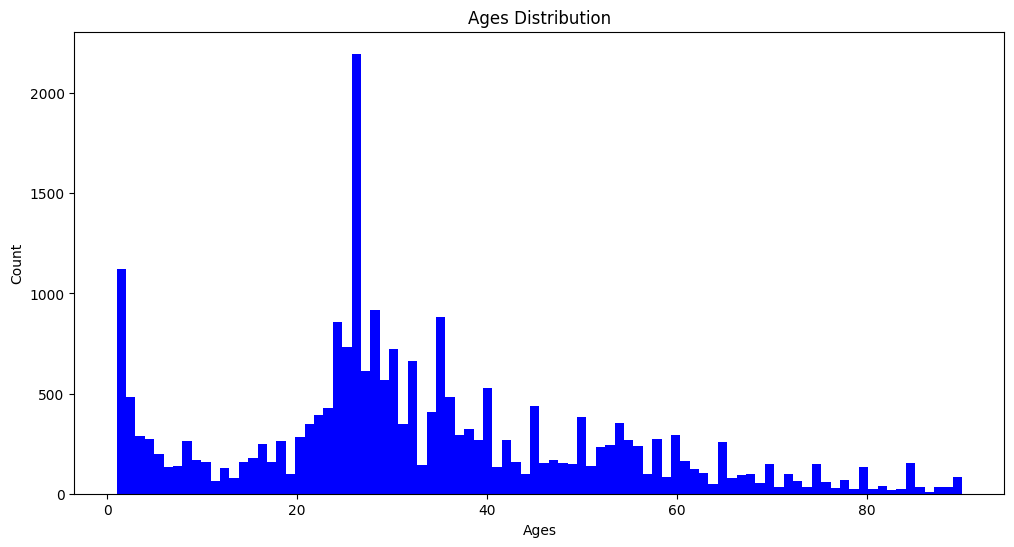

In [6]:
plt.figure(figsize=(12,6))
plt.hist(df["age"], bins=df["age"].max(), color="blue")
plt.title("Ages Distribution")
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

In [7]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_generator.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col="filename", y_col="age",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="raw",
    shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(
    validation_df,
    directory=data_dir,
    x_col="filename", y_col="age",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False)

Found 18896 validated image filenames.
Found 4725 validated image filenames.


In [8]:
base = ResNet50(include_top=False, weights="imagenet", input_shape=(*img_size, 3))
base.trainable = False

In [9]:
model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="linear")])

In [10]:
model.compile(
    optimizer=Adam(1e-2),
    loss="mae",
    metrics=["mae"])

In [11]:
callbacks = [ReduceLROnPlateau(monitor="mae", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
            EarlyStopping(monitor="mae", patience=5, restore_best_weights=True, verbose=1)]

In [12]:
history = model.fit(
    train_flow,
    validation_data=validation_flow,
    epochs=35,
    callbacks=callbacks)

e:\Software\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 515s 426ms/step - loss: 10.1705 - mae: 10.1705 - val_loss: 7.9033 - val_mae: 7.9033 - learning_rate: 0.0100
Epoch 2/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 318s 269ms/step - loss: 9.6563 - mae: 9.6563 - val_loss: 7.9148 - val_mae: 7.9148 - learning_rate: 0.0100
Epoch 3/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 303s 257ms/step - loss: 9.5083 - mae: 9.5083 - val_loss: 9.7605 - val_mae: 9.7605 - learning_rate: 0.0100
Epoch 4/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 312s 264ms/step - loss: 9.6800 - mae: 9.6800 - val_loss: 7.7104 - val_mae: 7.7104 - learning_rate: 0.0100
Epoch 5/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 313s 265ms/step - loss: 9.4751 - mae: 9.4751 - val_loss: 7.7955 - val_mae: 7.7955 - learning_rate: 0.0100
Epoch 6/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 301s 255ms/step - loss: 9.3997 - mae: 9.3997 - val_loss: 7.8821 - val_mae: 7.8821 - learning_rate: 0.0100
Epoch 7/35
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 301s 255ms/step - loss: 9.5171 - mae: 9.5171 - val_loss: 7.7733 - va

In [13]:
def predict_age(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = preprocess_input(img.astype("float32"))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0][0]
    return pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted age: 39.0 years


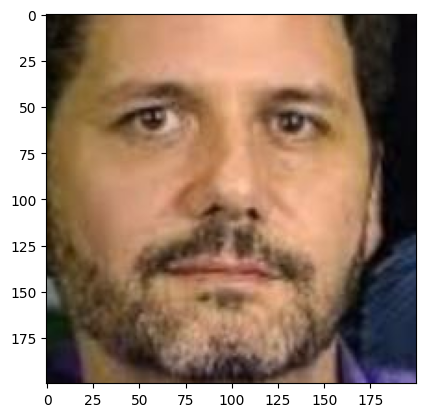

In [14]:
test_image_path = "UTKFace_dataset/45_0_0_20170117170038938.jpg.chip.jpg"
test_image = cv2.imread(test_image_path)
print(f"Predicted age: {predict_age(test_image_path):.1f} years")

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()